In [62]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import datasets
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

IGNORE_NON_PLAYERS = True
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [75]:
# load in dataset
animal_crossing_data = pd.read_csv('./Cleaned-Data-for-Data-Science (working on D6 and D7).csv')

# option to drop those who do not play ACNH or not
if IGNORE_NON_PLAYERS:
    animal_crossing_data.drop(animal_crossing_data[animal_crossing_data['Id'].isin([21, 26])].index, inplace=True)

# take only columns relating to environmental perception or socio demographic
animal_crossing_data = animal_crossing_data[[
    'A1_1_What_is_your_nationality_ALTERED',
    'A1_2_Region__generated_from_A1_1_ALTERED',
    'A2_What_is_your_biological_sex_',
    'A3_What_is_the_highest_educational_level_you_have_completed',
    'A4_Do_you_have_a_pet_or__a_garden_at_home_',
    'A5_What_is_your_age_',
    'A6_Please_specify_your_ethnicity_',
    'A7_What_is_your_marital_status_',
    'A8_Employment_Status__Are_you_currently__',
    'C1_How_much_do_you_agree_with_the_following_statements___We_are_approaching_the_limit_of_the_number_of_people_the_earth_can_support_',
    'C2_How_much_do_you_agree_with_the_following_statements___Humans_have_the_right_to_modify_the_natural_environment_to_suit_their_needs__',
    'C3_How_much_do_you_agree_with_the_following_statements___When_humans_interfere_with_nature_it_often_produces_disastrous_consequences__',
    'C4_How_much_do_you_agree_with_the_following_statements___Human_ingenuity_will_insure_that_we_do_not_make_the_Earth_unlivable_',
    'C5_How_much_do_you_agree_with_the_following_statements___Humans_are_seriously_abusing_the_environment__',
    'C6_How_much_do_you_agree_with_the_following_statements___The_Earth_has_plenty_of_natural_resources_if_we_just_learn_how_to_develop_them__',
    'C7_How_much_do_you_agree_with_the_following_statements___Plants_and_animals_have_as_much_right_as_humans_to_exist__',
    'C8_How_much_do_you_agree_with_the_following_statements___The_balance_of_nature_is_strong_enough_to_cope_with_the_impacts_of_modern_industrial_nations_',
    'C9_How_much_do_you_agree_with_the_following_statements___Despite_our_special_abilities__humans_are_still_subject_to_the_laws_of_nature__',
    'C10_How_much_do_you_agree_with_the_following_statements___The_so_called__ecological_crisis__facing_humankind_has_been_greatly_exaggerated__',
    'C11_How_much_do_you_agree_with_the_following_statements___The_Earth_is_like_a_spaceship_with_very_limited_room_and_resources__',
    'C12_How_much_do_you_agree_with_the_following_statements___Humans_were_meant_to_rule_over_the_rest_of_nature__',
    'C13_How_much_do_you_agree_with_the_following_statements___The_balance_of_nature_is_very_delicate_and_easily_upset__',
    'C14_How_much_do_you_agree_with_the_following_statements___Humans_will_eventually_learn_enough_about_how_nature_works_to_be_able_to_control_it__',
    'C15_How_much_do_you_agree_with_the_following_statements___If_things_continue_on_their_present_course__we_will_soon_experience_a_major_ecological_catastrophe__',
]]


# rename columns for convenience
animal_crossing_data.columns = [
    'Nationality',
    'Region',
    'Biological sex',
    'Educational Level',
    'Pet or garden',
    'Age',
    'Ethnicity',
    'Marital status',
    'Employment Status',
    'C1',
    'C2',
    'C3',
    'C4',
    'C5',
    'C6',
    'C7',
    'C8',
    'C9',
    'C10',
    'C11',
    'C12',
    'C13',
    'C14',
    'C15',
]

# reset the None values in the pet or garden column
animal_crossing_data.loc[animal_crossing_data['Pet or garden'].isnull(), 'Pet or garden'] = "None"

# reverse the scaling on the even numbered C columns so bigger numbers imply environmental perception leaning towards nature rather than human
# NOTE: dugyu says that this has already been done (check on dataset/ website for the dataset etc.)

# calculate the environmental perception score as the averaged perception rescaled to (0 - 100) and drop the original perception columns

<class 'pandas.core.frame.DataFrame'>
Index: 638 entries, 0 to 639
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Nationality        638 non-null    object
 1   Region             638 non-null    object
 2   Biological sex     638 non-null    object
 3   Educational Level  638 non-null    object
 4   Pet or garden      638 non-null    object
 5   Age                638 non-null    int64 
 6   Ethnicity          638 non-null    object
 7   Marital status     638 non-null    object
 8   Employment Status  638 non-null    object
 9   C1                 638 non-null    int64 
 10  C2                 638 non-null    int64 
 11  C3                 638 non-null    int64 
 12  C4                 638 non-null    int64 
 13  C5                 638 non-null    int64 
 14  C6                 638 non-null    int64 
 15  C7                 638 non-null    int64 
 16  C8                 638 non-null    int64 
 17  C9

In [ ]:
# pre-processing: encode all the categorical socio-economic variables we have (one hot encoded?)

In [ ]:
# split the data set into the  training and test

In [ ]:
# fit a random forest classifier

# evaluate against the test data - is this okay?

In [ ]:
# try running a gridsearch cross validation to find best parameters

# extract the best generated classifier and its score

In [11]:
# load in our dataset, labels and data
iris = datasets.load_iris(as_frame=True)
features    = iris.data
labels      = iris.target
label_names = iris.target_names

# split the data into trainign and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.75, random_state=None)

# show some of the training data
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
89,5.5,2.5,4.0,1.3
83,6.0,2.7,5.1,1.6
8,4.4,2.9,1.4,0.2
14,5.8,4.0,1.2,0.2
15,5.7,4.4,1.5,0.4


In [12]:
# 1: building DT with gini index criterion using only petal width and length

petal_dt = tree.DecisionTreeClassifier()
petal_dt.fit(X_train[['petal width (cm)', 'petal length (cm)']], y_train)

DecisionTreeClassifier()

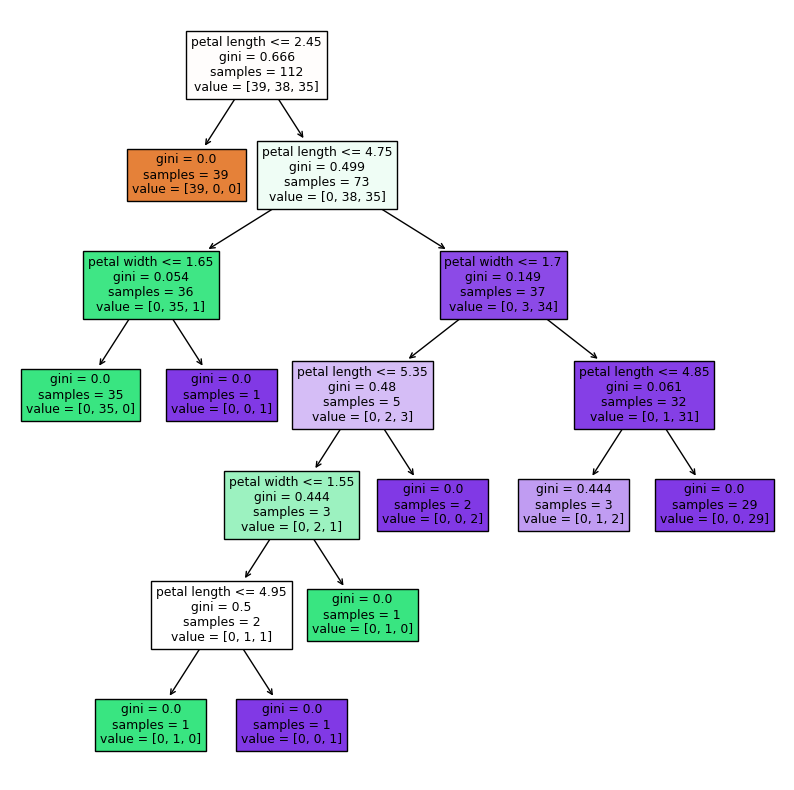

In [13]:
# 2: visualise DT from previous step

plt.figure(figsize=(10, 10))
tree.plot_tree(petal_dt, feature_names = ['petal width', 'petal length'], filled=True)
plt.show()


    Accuracy:  0.9736842105263158
    Precision: 0.975328947368421
    Recall:    0.9736842105263158
    F1 score:  0.9735365763637706



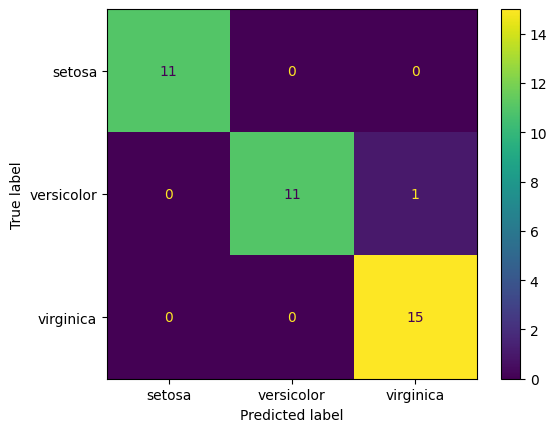

In [14]:
# 3: evalute the model, create confusion matrix, report accuracy, precision, recall, F1 score, overfitting or not, observe tree

y_pred = petal_dt.predict(X_test[['petal width (cm)', 'petal length (cm)']])

# calculate our scores
accu = metrics.accuracy_score (y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred, average='weighted')
reca = metrics.recall_score   (y_test, y_pred, average='weighted')
f1sc = metrics.f1_score       (y_test, y_pred, average='weighted')
print(f'''
    Accuracy:  {accu}
    Precision: {prec}
    Recall:    {reca}
    F1 score:  {f1sc}
''')

# generate confusion matrix and show
petal_cf = metrics.confusion_matrix(y_test, y_pred)
dis = metrics.ConfusionMatrixDisplay(petal_cf, display_labels=label_names)
dis.plot()
plt.show()


In [15]:
# 4: build DT wtih gini index criterion using all variables

full_dt = tree.DecisionTreeClassifier()
full_dt.fit(X_train, y_train)

DecisionTreeClassifier()

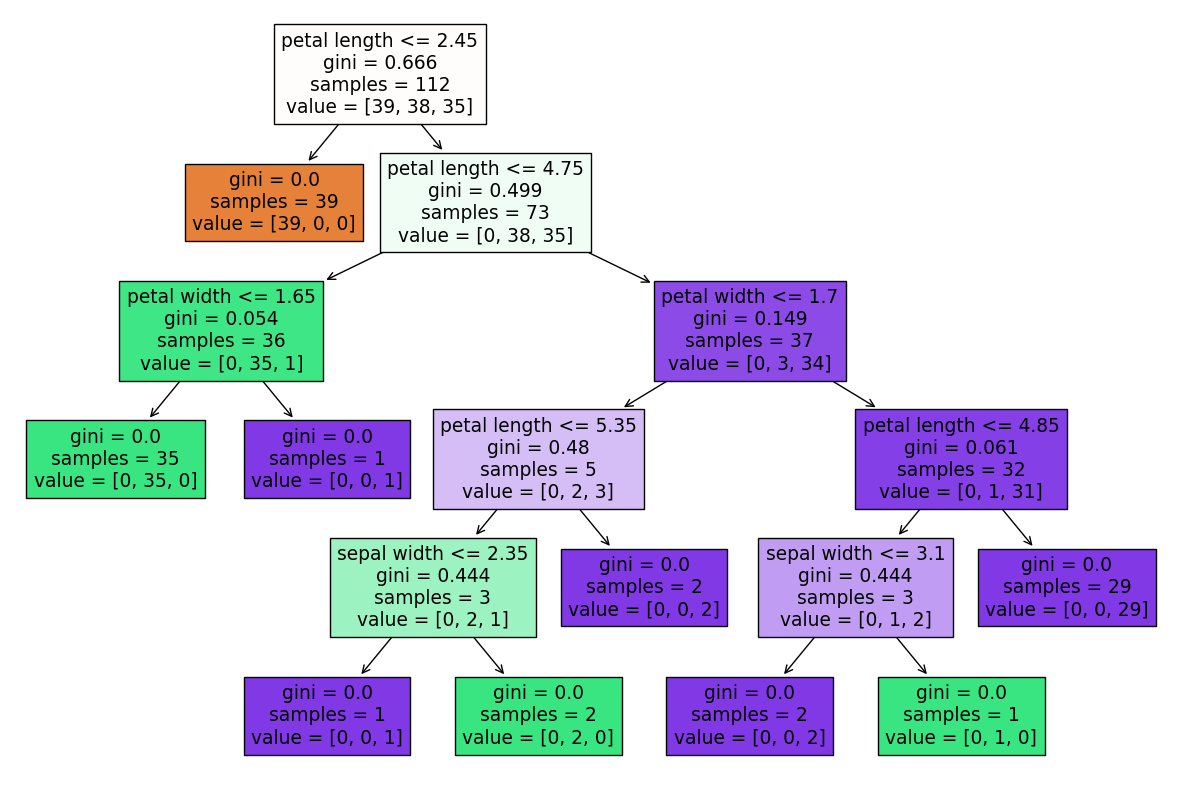

In [16]:
# 5: visualise DT from previous step

plt.figure(figsize=(15, 10))
tree.plot_tree(full_dt, feature_names = ['sepal length', 'sepal width', 'petal length', 'petal width'], filled=True)
plt.show()


    Accuracy:  0.9473684210526315
    Precision: 0.9473684210526315
    Recall:    0.9473684210526315
    F1 score:  0.9473684210526315



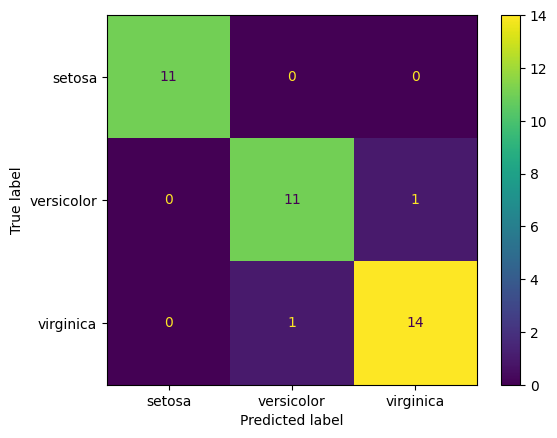

In [17]:
# 6: evaluate the model, give same measures as before, compare to previous model

y_pred = full_dt.predict(X_test)

# calculate our scores
accu = metrics.accuracy_score (y_test, y_pred)
prec = metrics.precision_score(y_test, y_pred, average='weighted')
reca = metrics.recall_score   (y_test, y_pred, average='weighted')
f1sc = metrics.f1_score       (y_test, y_pred, average='weighted')
print(f'''
    Accuracy:  {accu}
    Precision: {prec}
    Recall:    {reca}
    F1 score:  {f1sc}
''')

# generate confusion matrix and show
petal_cf = metrics.confusion_matrix(y_test, y_pred)
dis = metrics.ConfusionMatrixDisplay(petal_cf, display_labels=label_names)
dis.plot()
plt.show()